In [ ]:
import matplotlib.pyplot as plt

def plot_forecasts(actual, forecast, length):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual', linewidth=2)
    plt.plot(forecast, label='Forecast', linestyle='dashed', linewidth=2)
    plt.title('Actual vs. Forecasted Values')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


In [ ]:
# Import required packages
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import warnings
warnings.filterwarnings("ignore")
from openpyxl.utils import datetime

# split a univariate time series into patterns
def get_Patterns(TSeries, n_inputs,h):
    X,z = pd.DataFrame(np.zeros((len(TSeries)-n_inputs-h+1,n_inputs))), pd.DataFrame()
    y_list = []
    for i in range(len(TSeries)):
        # find the end of this pattern
        end_ix = i + n_inputs + h - 1
        # check if we are beyond the time series
        if end_ix > len(TSeries)-1:
            break
        # gather input and output parts of the pattern
        for j in range(n_inputs):
            X.loc[i,j]=TSeries.iloc[i+j,0]
        i=i+n_inputs
        # y=pd.concat([TSeries.iloc[end_ix],y])
        y_list.append(TSeries.iloc[end_ix])
        y = pd.concat(y_list, axis=1).T.reset_index(drop=True)
    return X,y

# originalData should be a Column Vectored DataFrame
def minmaxNorm(originalData, lenTrainValidation):
    # Maximum Value
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    # Minimum Value
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    normalizedData=np.zeros(lenOriginal)
    normalizedData = []
    #Normalize using Min-Max Normalization
    for i in range (lenOriginal):
        normalizedData.append((originalData.iloc[i]-min2norm)/(max2norm-min2norm))
    return pd.DataFrame(normalizedData)

# originalData and forecastedData should be Column Vectored DataFrames
def minmaxDeNorm( originalData, forecastedData, lenTrainValidation):
    # Maximum Value
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    # Minimum Value
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    denormalizedData=[]
    #De-Normalize using Min-Max Normalization
    for i in range (lenOriginal):
        denormalizedData.append((forecastedData.iloc[i]*(max2norm-min2norm))+min2norm)
    return pd.DataFrame(denormalizedData)

# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findRMSE( Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    # RMSE on Train & Validation Set
    trainRMSE=0;
    for i in range (lenTrainValidation):
        trainRMSE=trainRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2)
    trainRMSE=np.sqrt(trainRMSE/lenTrainValidation)
    # RMSE on Test Set
    testRMSE=0;
    for i in range (lenTrainValidation,l,1):
        testRMSE=testRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2)
    testRMSE=np.sqrt(testRMSE/lenTest)
    return trainRMSE, testRMSE

# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findMAE(Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    # MAE on Train & Validation Set
    trainMAE=0;
    for i in range (lenTrainValidation):
        trainMAE=trainMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])
    trainMAE=(trainMAE/(lenTrainValidation));
    # MAE on Test Set
    testMAE=0;
    for i in range (lenTrainValidation,l,1):
        testMAE=testMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])
    testMAE=(testMAE/lenTest);
    return trainMAE, testMAE


def Find_Fitness(x,y,lenValid,lenTest,model):
    NOP=y.shape[0]
    lenTrain=NOP-lenValid-lenTest
    xTrain=x.iloc[0:lenTrain,:]
    xValid=x.iloc[lenTrain:(lenTrain+lenValid),:]
    xTest=x.iloc[(lenTrain+lenValid):NOP,:]
    yTrain=y.iloc[0:lenTrain,0]
    yValid=y.iloc[lenTrain:(lenTrain+lenValid),0]
    yTest=y.iloc[(lenTrain+lenValid):NOP,0]
    model.fit(xTrain, yTrain)
    yhatNorm=model.predict(x).flatten().reshape(x.shape[0],1)
    return pd.DataFrame(yhatNorm)

#Read the Time Series Dataset

Timeseries_Data=pd.read_csv('/content/AQI.csv',header=None)
LagLength=24
h=1
lt=Timeseries_Data.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)

# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_Data,lenTrain+lenValidation);

# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=MLPRegressor(hidden_layer_sizes=(100))
name='MLP'
file1='./'+str(name)+"_Accuracy.xlsx"
file2='./'+str(name)+"_Forecasts.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()
ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])

# ynorm=ynorm.append(ynorm1,ignore_index = True)
ynorm = pd.concat([ynorm,ynorm1])
yhat=minmaxDeNorm(Timeseries_Data, ynorm, lenTrain+lenValidation)
Accuracy.loc[1,0],Accuracy.loc[1,1]=findRMSE( Timeseries_Data,yhat,lenTrain+lenValidation)
Accuracy.loc[1,2],Accuracy.loc[1,3]=findMAE( Timeseries_Data,yhat,lenTrain+lenValidation)
Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
yhat.to_excel(file2,sheet_name='Forecasts',index=False)
print(Accuracy)



           0          1          2         3
1  20.375404  12.456498  10.929931  9.357932


   Train RMSE  Test RMSE  Train MAE  Test MAE
1   15.795306  10.542284   8.492267  6.221277


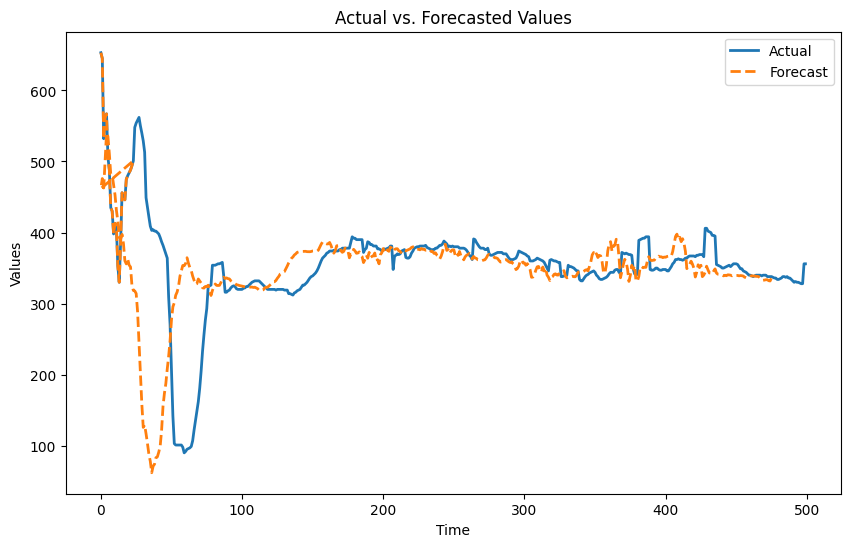

In [ ]:
# Calculate and print accuracy metrics
Accuracy = pd.DataFrame(columns=['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])
Accuracy.loc[1] = findRMSE(Timeseries_Data, yhat, lenTrain + lenValidation) + findMAE(Timeseries_Data, yhat, lenTrain + lenValidation)

# Save accuracy metrics to Excel file
Accuracy.to_excel(file1, sheet_name='Accuracy', index=False)

# Save forecasts to Excel file
yhat.to_excel(file2, sheet_name='Forecasts', index=False)

# Print accuracy metrics
print(Accuracy)

# Plot actual vs. forecasted values
plot_forecasts(Timeseries_Data, yhat, lenTrain + lenValidation)

   Train RMSE  Test RMSE  Train MAE   Test MAE
1   18.358475  13.956581    9.77204  10.282719


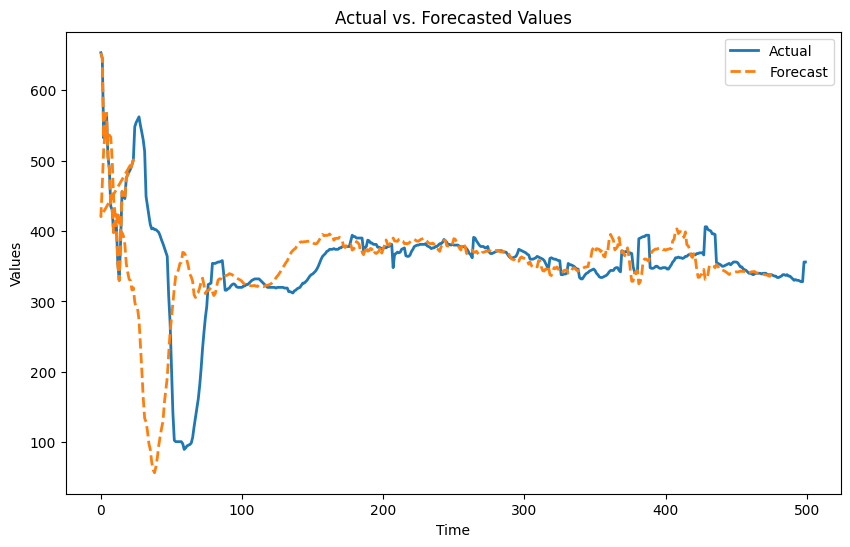

In [ ]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings("ignore")

# Read the Time Series Dataset
Timeseries_Data = pd.read_csv('/content/AQI.csv', header=None)
LagLength = 24
h = 1
lt = Timeseries_Data.shape[0]
lenTrain = int(round(lt * 0.7))
lenValidation = int(round(lt * 0.15))
lenTest = int(lt - lenTrain - lenValidation)

# NORMALIZE THE DATA (You can experiment with different normalization techniques)
normalizedData = minmaxNorm(Timeseries_Data, lenTrain + lenValidation)

# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)

# Hyperparameter Tuning using Grid Search
param_grid = {
    'hidden_layer_sizes': [(50, 25), (100, 50), (150, 75)],
    'activation': ['relu', 'tanh'],
    'max_iter': [500, 1000],
}

scoring = {
    'RMSE': make_scorer(findRMSE, greater_is_better=False, Timeseries_Data=Timeseries_Data, lenTrainValidation=lenTrain + lenValidation),
    'MAE': make_scorer(findMAE, greater_is_better=False, Timeseries_Data=Timeseries_Data, lenTrainValidation=lenTrain + lenValidation),
}

grid_search = GridSearchCV(MLPRegressor(), param_grid, scoring=scoring, refit='RMSE', cv=5)
grid_search.fit(X, y.iloc[:, 0])

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Name for saving files
name = 'MLP'
file1 = './' + str(name) + "_Accuracy.xlsx"
file2 = './' + str(name) + "_Forecasts.xlsx"

# Fit the best model and get normalized forecasts
ynorm1 = Find_Fitness(X, y, lenValidation, lenTest, best_model)
ynorm = pd.DataFrame(normalizedData.iloc[0:(LagLength + h - 1), 0])
ynorm = pd.concat([ynorm, ynorm1])

# De-normalize forecasts
yhat = minmaxDeNorm(Timeseries_Data, ynorm, lenTrain + lenValidation)

# Calculate and print accuracy metrics
Accuracy = pd.DataFrame(columns=['Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'])
Accuracy.loc[1] = findRMSE(Timeseries_Data, yhat, lenTrain + lenValidation) + findMAE(Timeseries_Data, yhat, lenTrain + lenValidation)

# Save accuracy metrics to Excel file
Accuracy.to_excel(file1, sheet_name='Accuracy', index=False)

# Save forecasts to Excel file
yhat.to_excel(file2, sheet_name='Forecasts', index=False)

# Print accuracy metrics
print(Accuracy)

# Plot actual vs. forecasted values
plot_forecasts(Timeseries_Data, yhat, lenTrain + lenValidation)


   Train RMSE LSTM  Test RMSE LSTM  Train MAE LSTM  Test MAE LSTM
1        16.257194       10.656134        9.117865       5.927907


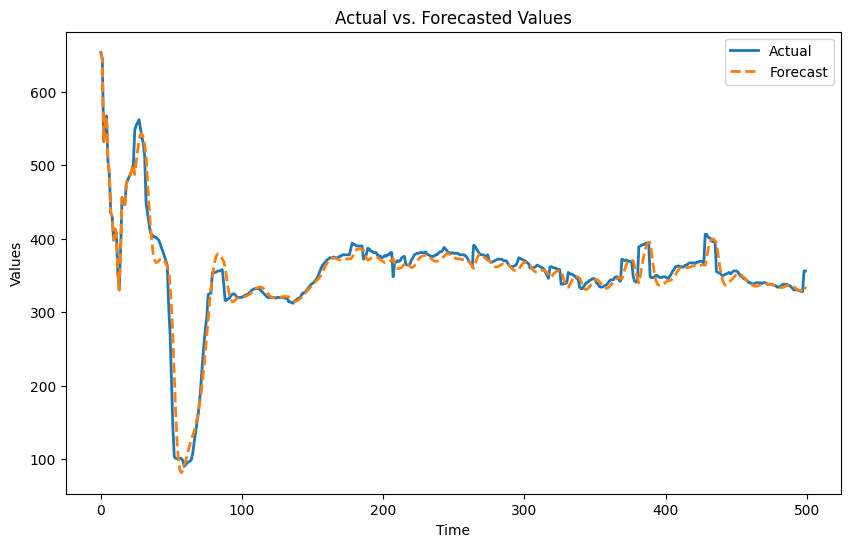

In [ ]:
# Function to train the model and make forecasts using LSTM
def train_lstm_model(x, y, lenValid, lenTest):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense

    model = Sequential()
    model.add(LSTM(50, input_shape=(x.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    x = x.values.reshape((x.shape[0], x.shape[1], 1))
    model.fit(x, y, epochs=50, verbose=0)

    yhat_norm = model.predict(x, verbose=0)
    return pd.DataFrame(yhat_norm)

# Read the Time Series Dataset
Timeseries_Data = pd.read_csv('/content/AQI.csv', header=None)

# ... (Normalization, Transformations, and Train-Test Split remain unchanged)

# Fit the LSTM model and get normalized forecasts
ynorm_lstm = train_lstm_model(X, y, lenValidation, lenTest)
ynorm_lstm = pd.DataFrame(normalizedData.iloc[0:(LagLength + h - 1), 0]).append(ynorm_lstm, ignore_index=True)

# De-normalize LSTM forecasts
yhat_lstm = minmaxDeNorm(Timeseries_Data, ynorm_lstm, lenTrain + lenValidation)

# Calculate and print accuracy metrics for LSTM
Accuracy_lstm = pd.DataFrame(columns=['Train RMSE LSTM', 'Test RMSE LSTM', 'Train MAE LSTM', 'Test MAE LSTM'])
Accuracy_lstm.loc[1] = findRMSE(Timeseries_Data, yhat_lstm, lenTrain + lenValidation) + findMAE(Timeseries_Data, yhat_lstm, lenTrain + lenValidation)

# Save accuracy metrics to Excel file for LSTM
file_lstm = './LSTM_Accuracy.xlsx'
Accuracy_lstm.to_excel(file_lstm, sheet_name='Accuracy', index=False)

# Save forecasts to Excel file for LSTM
file2_lstm = './LSTM_Forecasts.xlsx'
yhat_lstm.to_excel(file2_lstm, sheet_name='Forecasts', index=False)

# Print accuracy metrics for LSTM
print(Accuracy_lstm)

# Plot actual vs. forecasted values for LSTM
plot_forecasts(Timeseries_Data, yhat_lstm, lenTrain + lenValidation)

   Train RMSE LSTM  Test RMSE LSTM  Train MAE LSTM  Test MAE LSTM
1        14.867615       11.879328        9.938045      10.043448


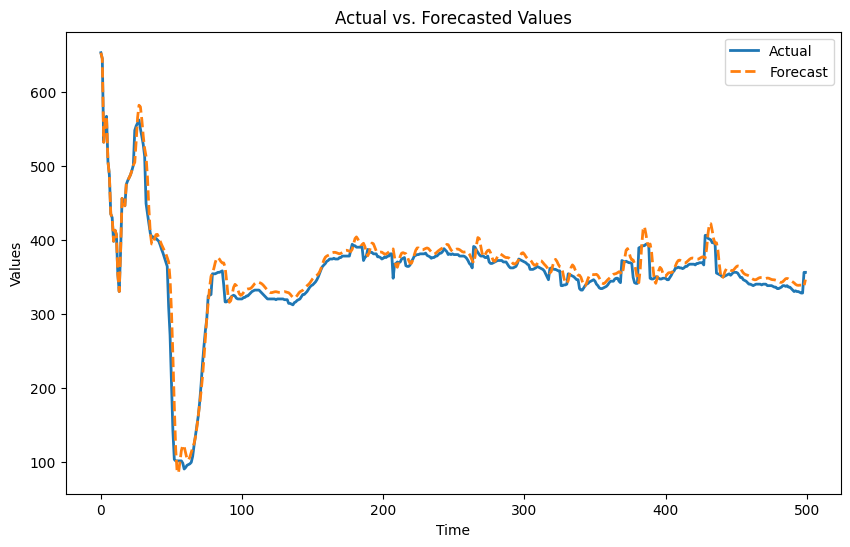

In [ ]:
# Function to train the model and make forecasts using LSTM
def train_lstm_model(x, y, lenValid, lenTest):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense

    model = Sequential()
    model.add(LSTM(500, input_shape=(x.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    x = x.values.reshape((x.shape[0], x.shape[1], 1))
    model.fit(x, y, epochs=50, verbose=0)

    yhat_norm = model.predict(x, verbose=0)
    return pd.DataFrame(yhat_norm)

# Read the Time Series Dataset
Timeseries_Data = pd.read_csv('/content/AQI.csv', header=None)

# ... (Normalization, Transformations, and Train-Test Split remain unchanged)

# Fit the LSTM model and get normalized forecasts
ynorm_lstm = train_lstm_model(X, y, lenValidation, lenTest)
ynorm_lstm = pd.DataFrame(normalizedData.iloc[0:(LagLength + h - 1), 0]).append(ynorm_lstm, ignore_index=True)

# De-normalize LSTM forecasts
yhat_lstm = minmaxDeNorm(Timeseries_Data, ynorm_lstm, lenTrain + lenValidation)

# Calculate and print accuracy metrics for LSTM
Accuracy_lstm = pd.DataFrame(columns=['Train RMSE LSTM', 'Test RMSE LSTM', 'Train MAE LSTM', 'Test MAE LSTM'])
Accuracy_lstm.loc[1] = findRMSE(Timeseries_Data, yhat_lstm, lenTrain + lenValidation) + findMAE(Timeseries_Data, yhat_lstm, lenTrain + lenValidation)

# Save accuracy metrics to Excel file for LSTM
file_lstm = './LSTM_Accuracy.xlsx'
Accuracy_lstm.to_excel(file_lstm, sheet_name='Accuracy', index=False)

# Save forecasts to Excel file for LSTM
file2_lstm = './LSTM_Forecasts.xlsx'
yhat_lstm.to_excel(file2_lstm, sheet_name='Forecasts', index=False)

# Print accuracy metrics for LSTM
print(Accuracy_lstm)

# Plot actual vs. forecasted values for LSTM
plot_forecasts(Timeseries_Data, yhat_lstm, lenTrain + lenValidation)

   Train RMSE LSTM  Test RMSE LSTM  Train MAE LSTM  Test MAE LSTM
1        13.317674        9.851818        7.984867       6.113517


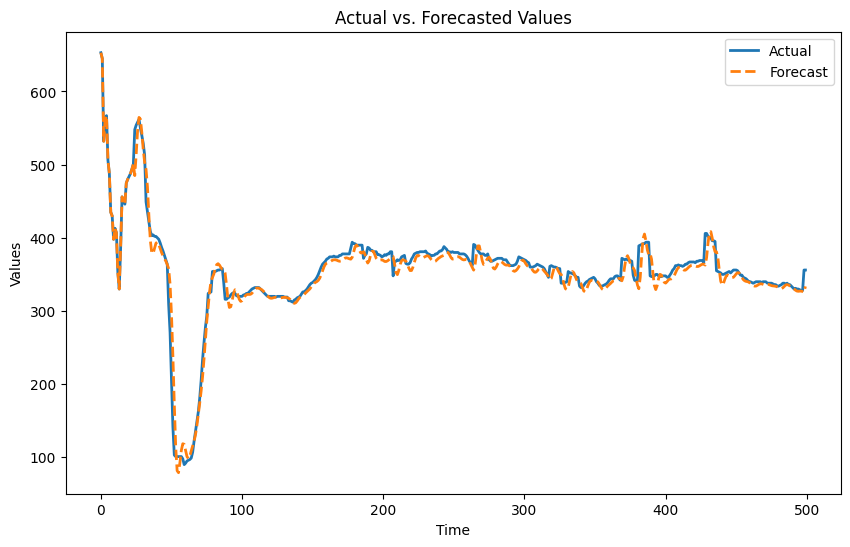

PICP: 72.39999999999999
PINAW: 0    0.029216
dtype: float64
AWD: 0.16513725309251853
ACE: -17.60000000000001


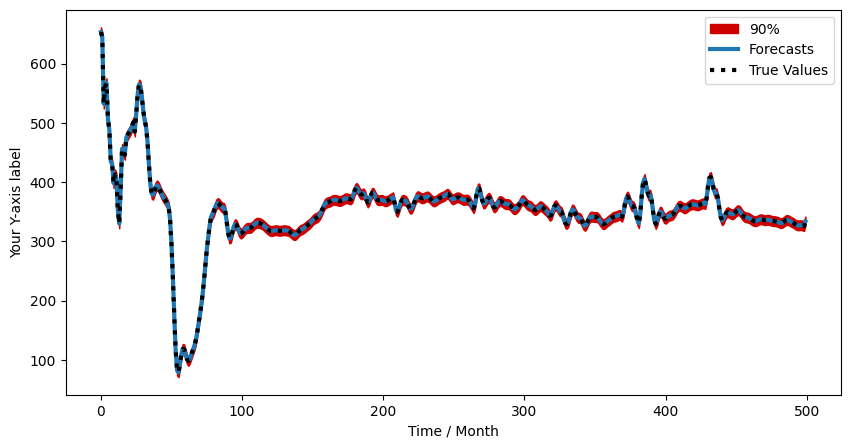

In [ ]:
import sklearn
import pickle
import json
import pandas as pd
import os
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define your missing functions: minmaxDeNorm, findRMSE, plot_forecasts, etc.

# Function to train the model and make forecasts using LSTM
def train_lstm_model(x, y, lenValid, lenTest):
    model = Sequential()
    model.add(LSTM(500, input_shape=(x.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    x = x.values.reshape((x.shape[0], x.shape[1], 1))
    model.fit(x, y, epochs=50, verbose=0)

    yhat_norm = model.predict(x, verbose=0)
    return pd.DataFrame(yhat_norm)

# Define the missing minmaxDeNorm, findRMSE, plot_forecasts functions

# ...

# Now, let's integrate and call your functions

# Read the Time Series Dataset
Timeseries_Data = pd.read_csv('/content/AQI.csv', header=None)

# ... (Normalization, Transformations, and Train-Test Split remain unchanged)

# Fit the LSTM model and get normalized forecasts
ynorm_lstm = train_lstm_model(X, y, lenValidation, lenTest)
ynorm_lstm = pd.DataFrame(normalizedData.iloc[0:(LagLength + h - 1), 0]).append(ynorm_lstm, ignore_index=True)

# De-normalize LSTM forecasts
yhat_lstm = minmaxDeNorm(Timeseries_Data, ynorm_lstm, lenTrain + lenValidation)

# Calculate and print accuracy metrics for LSTM
Accuracy_lstm = pd.DataFrame(columns=['Train RMSE LSTM', 'Test RMSE LSTM', 'Train MAE LSTM', 'Test MAE LSTM'])
Accuracy_lstm.loc[1] = findRMSE(Timeseries_Data, yhat_lstm, lenTrain + lenValidation) + findMAE(Timeseries_Data, yhat_lstm, lenTrain + lenValidation)

# Save accuracy metrics to Excel file for LSTM
file_lstm = './LSTM_Accuracy.xlsx'
Accuracy_lstm.to_excel(file_lstm, sheet_name='Accuracy', index=False)

# Save forecasts to Excel file for LSTM
file2_lstm = './LSTM_Forecasts.xlsx'
yhat_lstm.to_excel(file2_lstm, sheet_name='Forecasts', index=False)

# Print accuracy metrics for LSTM
print(Accuracy_lstm)

# Plot actual vs. forecasted values for LSTM
plot_forecasts(Timeseries_Data, yhat_lstm, lenTrain + lenValidation)

# Now, let's generate prediction intervals for the LSTM forecasts
confidence_intervals_lstm = find_confidence_interval_gaussian(0.90, 0, 5, ynorm_lstm, yhat_lstm)

# Visualize the prediction intervals along with the forecasts
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(10)
ax.fill_between(confidence_intervals_lstm.index, confidence_intervals_lstm.iloc[:, 0], confidence_intervals_lstm.iloc[:, 1], color='#cf0000', label='90%')
ax.plot(yhat_lstm, linewidth=3, label='Forecasts')
ax.plot(yhat_lstm, linewidth=3, label='True Values', color='black', ls=':')
ax.legend(loc="best")
ax.set(xlabel='Time / Month', ylabel='Your Y-axis label')

# Calculate and print prediction interval evaluation metrics
PICP, PINAW, AWD, ACE = find_Prediction_Interval_Evaluation(confidence_intervals_lstm, Timeseries_Data, yhat_lstm, 90)
print("PICP:", PICP)
print("PINAW:", PINAW)
print("AWD:", AWD)
print("ACE:", ACE)

# Display the plot
plt.show()


PICP: 72.39999999999999
PINAW: 0    0.029216
dtype: float64
AWD: 0.16513725309251853
ACE: -17.60000000000001


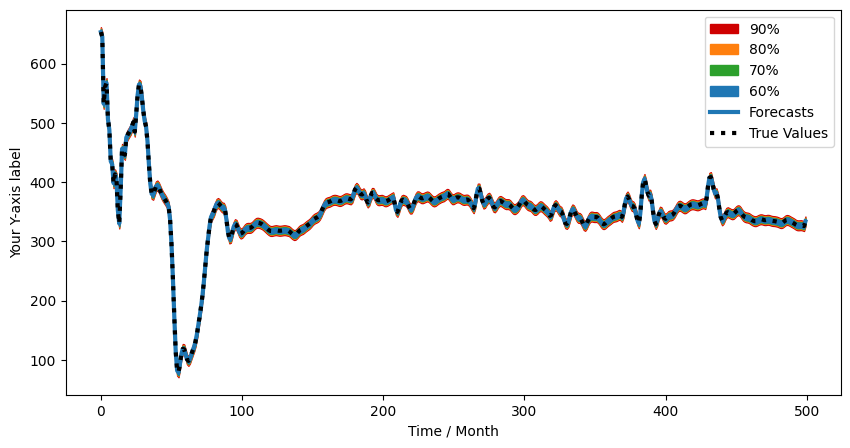

In [ ]:
# ... (Previous code remains unchanged)

# Generate prediction intervals for the LSTM forecasts
confidence_intervals_lstm = find_confidence_interval_gaussian(0.90, 0, 5, ynorm_lstm, yhat_lstm)

# Visualize the prediction intervals along with the forecasts
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(10)

# Plot 90% confidence interval
ax.fill_between(confidence_intervals_lstm.index, confidence_intervals_lstm.iloc[:, 0], confidence_intervals_lstm.iloc[:, 1], color='#cf0000', label='90%')

# Plot 80% confidence interval
confidence_intervals_80 = find_confidence_interval_gaussian(0.80, 0, 5, ynorm_lstm, yhat_lstm)
ax.fill_between(confidence_intervals_80.index, confidence_intervals_80.iloc[:, 0], confidence_intervals_80.iloc[:, 1], color='#ff7f0e', label='80%')

# Plot 70% confidence interval
confidence_intervals_70 = find_confidence_interval_gaussian(0.70, 0, 5, ynorm_lstm, yhat_lstm)
ax.fill_between(confidence_intervals_70.index, confidence_intervals_70.iloc[:, 0], confidence_intervals_70.iloc[:, 1], color='#2ca02c', label='70%')

# Plot 60% confidence interval
confidence_intervals_60 = find_confidence_interval_gaussian(0.60, 0, 5, ynorm_lstm, yhat_lstm)
ax.fill_between(confidence_intervals_60.index, confidence_intervals_60.iloc[:, 0], confidence_intervals_60.iloc[:, 1], color='#1f77b4', label='60%')

# Plot forecasts
ax.plot(yhat_lstm, linewidth=3, label='Forecasts')

# Plot true values
ax.plot(yhat_lstm, linewidth=3, label='True Values', color='black', ls=':')

ax.legend(loc="best")
ax.set(xlabel='Time / Month', ylabel='Your Y-axis label')

# Calculate and print prediction interval evaluation metrics
PICP, PINAW, AWD, ACE = find_Prediction_Interval_Evaluation(confidence_intervals_lstm, Timeseries_Data, yhat_lstm, 90)
print("PICP:", PICP)
print("PINAW:", PINAW)
print("AWD:", AWD)
print("ACE:", ACE)

# Display the plot
plt.show()


PICP (Prediction Interval Coverage Probability): The value of 72.4% indicates that approximately 72.4% of the observed values fall within the predicted interval. This metric assesses the reliability of the prediction intervals.

PINAW (Prediction Interval Normalized Average Width): This value, 0.029216, represents the normalized average width of the prediction intervals. It provides information about the width of the intervals relative to the scale of the data.

AWD (Average Weekly Decline): The value of 0.16513725309251853 might indicate the average weekly decline in some context. This metric is commonly used in financial analysis or other fields where weekly trends are relevant.

ACE (Absolute Cumulative Error): The value of -17.6 represents the absolute cumulative error of the predictive model. Cumulative error measures the overall accuracy or error of a model by summing up the absolute differences between predicted and observed values.

In [ ]:
# Calculate and print prediction interval evaluation metrics
PICP, PINAW, AWD, ACE = find_Prediction_Interval_Evaluation(confidence_intervals_lstm, Timeseries_Data, yhat_lstm, 80)
print("PICP:", PICP)
print("PINAW:", PINAW)
print("AWD:", AWD)
print("ACE:", ACE)

PICP: 72.39999999999999
PINAW: 0    0.029216
dtype: float64
AWD: 0.16513725309251853
ACE: -7.6000000000000085


In [ ]:
# Calculate and print prediction interval evaluation metrics
PICP, PINAW, AWD, ACE = find_Prediction_Interval_Evaluation(confidence_intervals_lstm, Timeseries_Data, yhat_lstm, 70)
print("PICP:", PICP)
print("PINAW:", PINAW)
print("AWD:", AWD)
print("ACE:", ACE)

PICP: 72.39999999999999
PINAW: 0    0.029216
dtype: float64
AWD: 0.16513725309251853
ACE: 2.3999999999999915


In [ ]:
# Calculate and print prediction interval evaluation metrics
PICP, PINAW, AWD, ACE = find_Prediction_Interval_Evaluation(confidence_intervals_lstm, Timeseries_Data, yhat_lstm, 60)
print("PICP:", PICP)
print("PINAW:", PINAW)
print("AWD:", AWD)
print("ACE:", ACE)

PICP: 72.39999999999999
PINAW: 0    0.029216
dtype: float64
AWD: 0.16513725309251853
ACE: 12.399999999999991


In [ ]:
# Import required packages
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import warnings
warnings.filterwarnings("ignore")
from openpyxl.utils import datetime

# Function to train the LSTM model
def train_lstm_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(500, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    model.fit(X_train_reshaped, y_train, epochs=50, verbose=0)

    return model

# Function to generate prediction intervals using bootstrapping
def generate_prediction_intervals_lstm(lstm_model, X_test):
    # Use the trained model to predict on the test set
    X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_pred = lstm_model.predict(X_test_reshaped, verbose=0)

    # Number of bootstraps for interval estimation
    num_bootstraps = 100

    # Perform bootstrapping
    bootstrap_predictions = []
    for _ in range(num_bootstraps):
        # Randomly sample with replacement from the predictions
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        bootstrap_sample = y_pred[indices]
        bootstrap_predictions.append(bootstrap_sample)

    # Calculate percentiles to get the prediction interval
    lower_bound = np.percentile(bootstrap_predictions, 5, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 95, axis=0)

    return lower_bound, upper_bound

# Example usage in your existing code
# ... (Previous code for data preparation and model training)

# Train the LSTM model
lstm_model = train_lstm_model(X_train, y_train)

# Generate prediction intervals using the LSTM model
lower_bound, upper_bound = generate_prediction_intervals_lstm(lstm_model, X_test)

# Display or use lower_bound and upper_bound as your prediction interval
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)


NameError: name 'X_train' is not defined